In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_load import *
from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

import os
import pickle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPool1D, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Reshape, UpSampling1D

from tensorflow.keras.models import Model

import tensorflow as tf

**TIP**: to reset initial weight to random, define mdoel in a function and use .get_model() !!

In [2]:
data_dict =  load_split_pool(1346, 430, 10, scale = True, normalize_by_wflux = True)

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


In [4]:
data_dict.keys()

dict_keys(['x', 'x_pooled', 'y', 'parameters', 'wavelengths'])

In [4]:
data_dict["x"]["train"].shape

(1346, 110001)

In [6]:
std_train = data_dict["x"]["train"].std()

In [15]:
x_train_demean = (data_dict["x"]["train"] - data_dict["x"]["train"].mean())

In [26]:
std_seq = np.linspace(0.1, 1, 100)
proportion_list = []

for std_margin in std_seq:
    proportion = (np.abs(x_train_demean) < std_margin*std_train).mean()
    proportion_list.append(proportion)

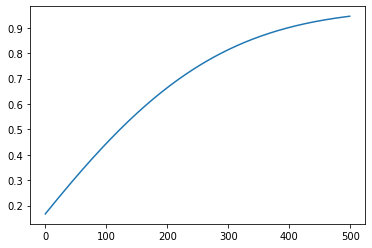

In [27]:
fig,ax = plt.subplots()
ax.plot(proportion_list)

In [20]:
(np.abs(x_train_demean) < 0.5*std_train).mean()

0.7027991289502393

In [17]:
np.abs(x_train_demean) < 2*std_train

array([[False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False]])

# Train-val data as tensors

In [6]:
x_train = data_dict["x_pooled"]["train"]
x_val = data_dict["x_pooled"]["val"]

x_train = tf.expand_dims(x_train, 1)
x_val = tf.expand_dims(x_val, 1)

In [7]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))

# Process the datasets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))


train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

# Autoencoder functions

In [11]:

encoded_dim = 50

def get_simple_autoencoder(encoded_dim):
    '''
    Get 4-layer auroencoder Model instance, with bottlencek of size "encoded_dim"
    '''

    encoder = Sequential([
        Dense(264, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l1(0)),
        BatchNormalization(),
        Dense(encoded_dim, activity_regularizer=regularizers.l1(0) ),
    ])
    print(encoder.summary())
    
    decoder = Sequential([
        Dense(264, input_shape = (1, encoded_dim), activation = 'relu', activity_regularizer=regularizers.l1(0)),
        BatchNormalization(),
        Dense(11001, activity_regularizer=regularizers.l1(0)),
    ])
    
    print(decoder.summary())
    
    autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
    
    return(autoencoder)

In [12]:
def get_6layer_autoencoder(encoded_dim):
    '''
    Get 6-layer auroencoder Model instance, with bottlencek of size "encoded_dim"
    '''  
    
    reg_alpha = 0
    encoder = Sequential([
        Dense(128, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(64, activation = "relu", activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(encoded_dim, activity_regularizer=regularizers.l2(reg_alpha) ),
    ])
    print(encoder.summary())

    decoder = Sequential([
        Dense(64, input_shape = (1, encoded_dim) , activation = 'relu', activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(128, activation = 'relu', activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(11001, activity_regularizer=regularizers.l2(reg_alpha)),
    ])

    print(decoder.summary())

    autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
    
    return(autoencoder)

In [8]:
def rescale_back(observation, mean, std, flux):
    '''
    Reverse standardisation using the given parameters
    '''
    return( (observation*std + mean)*flux ) 


def get_loss_autoencoder(x_val, get_model_function, encoded_dim, epochs, verbose = 'auto', 
                         rescale = True, mean = None, std = None, flux = None):
    '''
    Calculate RMSE of autoencoder for a given bottleneck and number of epochs to train.
    Uses early stopping (to allow training many models with the same number of epochs)
    
    Inputs:
    - get_model_function: autoencoder Model instance
    - encoded_dim: bottleneck size
    - epochs: number of epochs used to train
    (train and al set loaded as global vars.)
    
    Outputs:
    - RMSE loss
    - plot of train and test loss vs epoch number

    '''
    
    autoencoder = get_model_function(encoded_dim)  
    
    autoencoder.reset_states()
    
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

    autoencoder.compile(loss = 'mean_squared_error', optimizer="Adam") # since output is zero or 1 use binary loss
    # default optimiser: RMS propr
    autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
                                    verbose = verbose, callbacks = earlystopping)
    
    fig, ax = plt.subplots()
    ax.plot(autoenc_history.history["loss"], label = "loss")
    ax.plot(autoenc_history.history["val_loss"], label = "val_loss")
    ax.legend()
    
    print(fig)
    
    x_predicted_val = autoencoder.predict(test_dataset)
    print("Prediction shape", x_predicted_val.shape)

    if rescale == True:
        x_val = rescale_back(x_val, mean, std, flux)
        x_predicted_val = rescale_back( x_predicted_val, mean, std, flux )


    autoenc_loss = ((x_predicted_val.ravel() - x_val.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)
    print("Loss:", autoenc_loss)
    
    return(autoenc_loss, fig)

# Finding the best bottleneck size for both 4 and 6 layer autoencoders

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Latent space size 1
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 264)            1056      
_________________________________________________________________
dense_21 (Dense)             (None, 1, 1)              265       
Total params: 2,905,849
Trainable params: 2,905,321
Non-trainable params: 528
_________________________________________________________________
None
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1, 264)            528       
_________________________________________________________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0018061203730327102
Latent space size 8
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization_24 (Batc (None, 1, 264)            1056      
_________________________________________________________________
dense_49 (Dense)             (None, 1, 8)              2120      
Total params: 2,907,704
Trainable params: 2,907,176
Non-trainable params: 528
_______________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0015666884766384925
Latent space size 12
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization_32 (Batc (None, 1, 264)            1056      
___________________________________________________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0015507871529531893
Latent space size 16
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization_40 (Batc (None, 1, 264)            1056      
_________________________________________________________________
dense_81 (Dense)             (None, 1

Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0015104784952127107


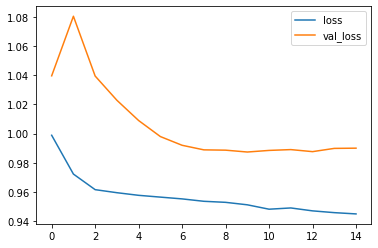

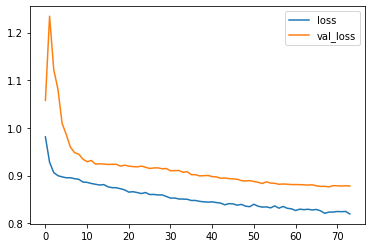

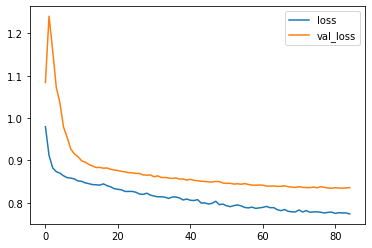

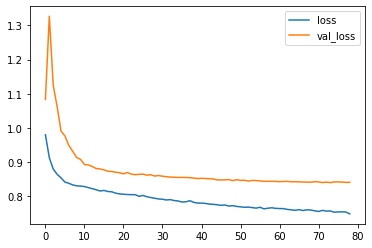

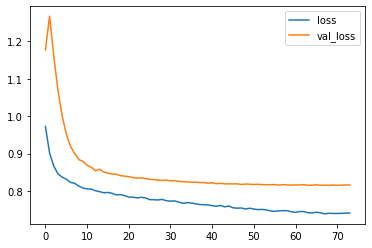

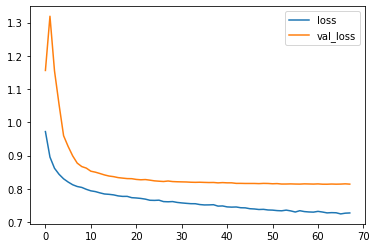

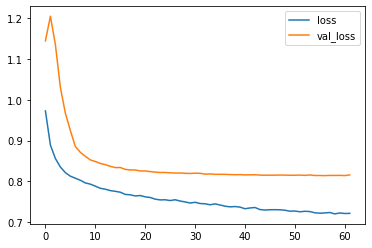

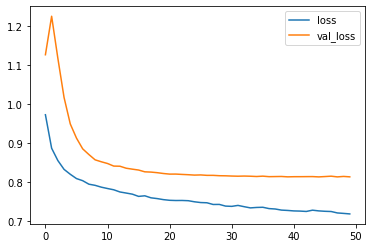

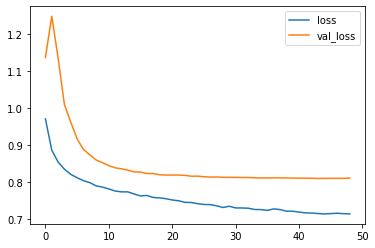

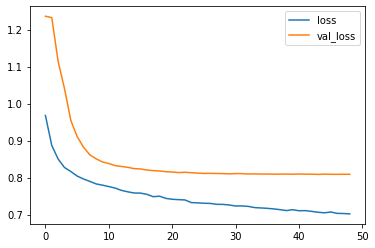

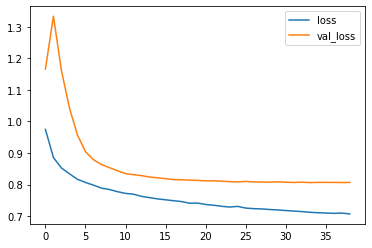

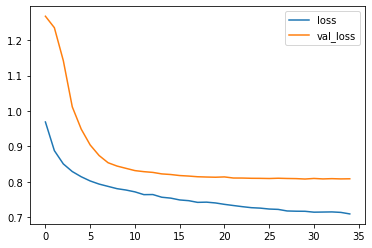

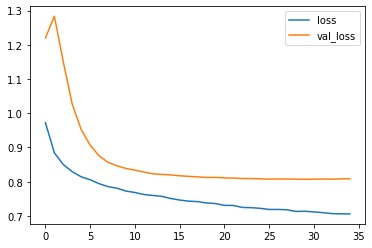

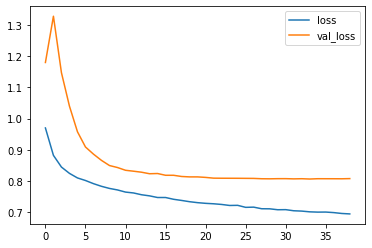

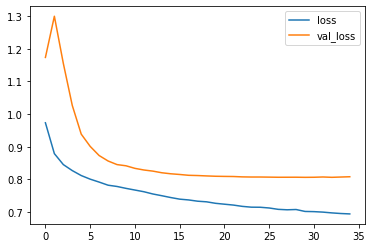

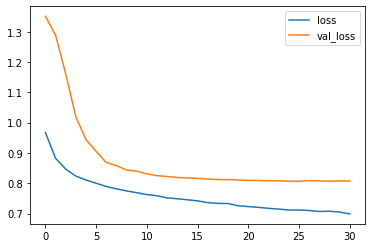

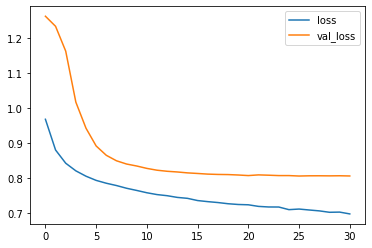

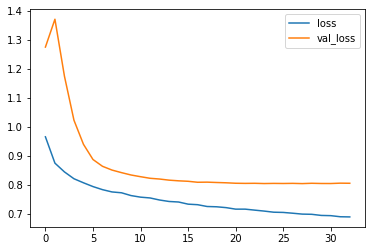

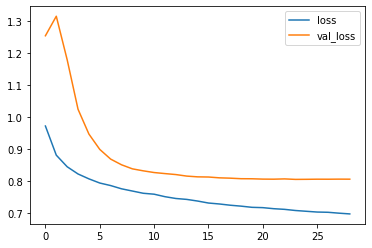

In [17]:
# Fit and evaluate 4 layer autoencoder for different sizes of bottleneck

autoenc_simple_loss = list()

latent_space_size_list = list( np.arange(1, 20, 1) )
print( latent_space_size_list )

for latent_space_size in latent_space_size_list:
    
    print("Latent space size", latent_space_size)
    
    loss, fig = get_loss_autoencoder(x_val, get_simple_autoencoder, latent_space_size, 100, verbose = '0', 
                                     rescale = True, mean = data_dict["parameters"]["mean"], std = data_dict["parameters"]["std"],
                                    flux = data_dict["x_pooled"]["val_df_pooled_total_flux"])
    fig
    
    autoenc_simple_loss.append( loss )

In [18]:
# Pickle the results

# put results into a dictionary
autoenc_simple_loss_dict = dict()
autoenc_simple_loss_dict["loss"] = autoenc_simple_loss
autoenc_simple_loss_dict["dim"] = latent_space_size_list



In [19]:
# pickle
dump_object("simple_autoencoder_loss_finegrid_wflux", autoenc_simple_loss_dict)

()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Latent space size 1
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_48 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_97 (Dense)             (None, 1, 64)             8256      
_________________________________________________________________
batch_normalization_49 (Batc (None, 1, 64)             256       
_________________________________________________________________
dense_98 (Dense)             (None, 1, 1)              65        
Total params: 1,417,345
Trainable params: 1,416,961
Non-trainable params: 384
_________________________________________________________________
None
Model: "sequen

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0019705317861591354
Latent space size 5
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_64 (Batc (None, 1, 128)            512       
_____________

Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016862073551870956
Latent space size 8
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_76 (Batc (None, 1, 128)            512       
______________________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0017087502408107628
Latent space size 11
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_88 (Batc (None, 1, 128)            512       
____________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016738891045260892
Latent space size 14
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_100 (Bat (None, 1, 128)            512       

Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016919482522810595
Latent space size 17
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_112 (Bat (None, 1, 128)            512       
_________________________________________________________________
dense_193 (Dense)            (None, 1, 64)             8256      
_________________________________________________________________
batch_normalization_113 (B

Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016513053471943627


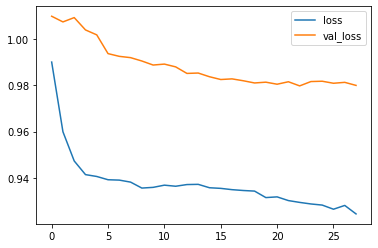

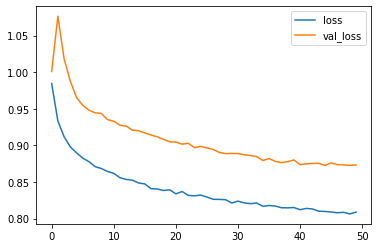

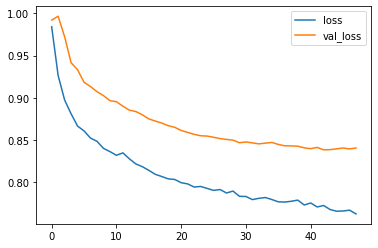

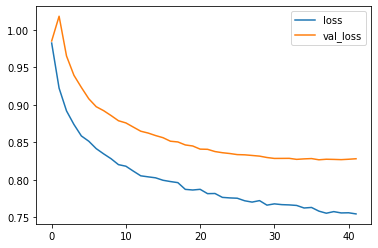

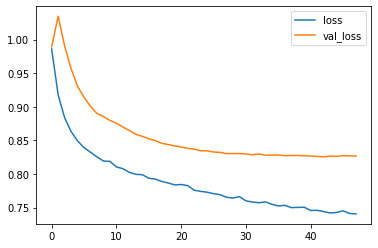

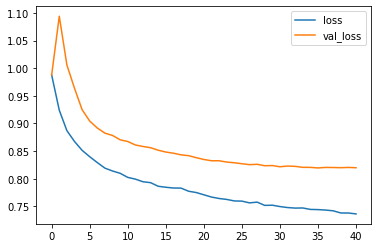

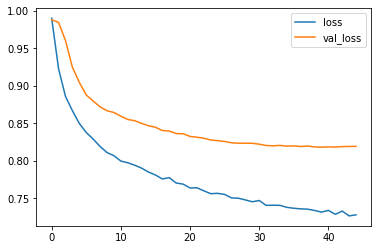

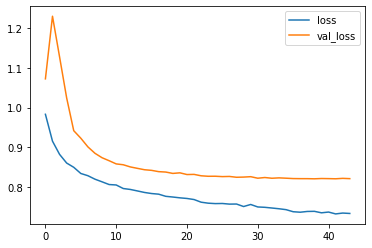

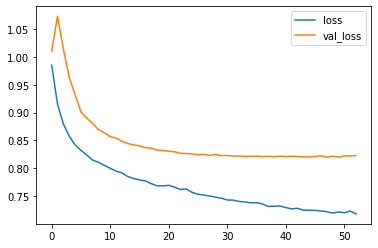

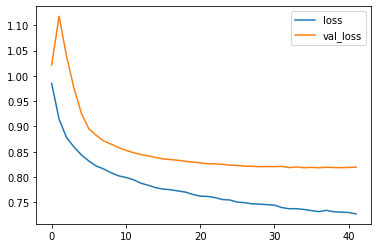

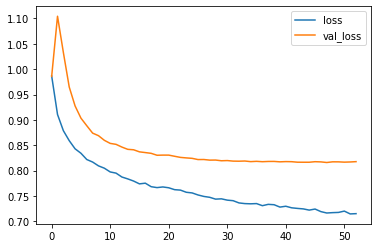

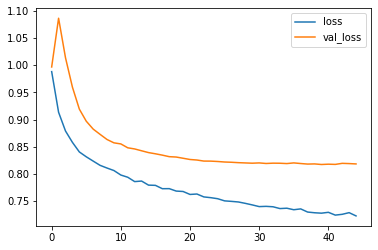

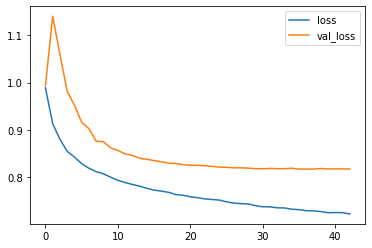

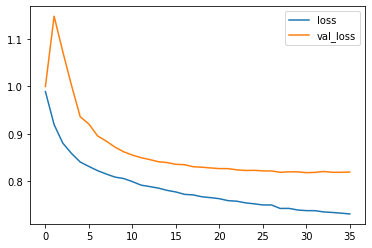

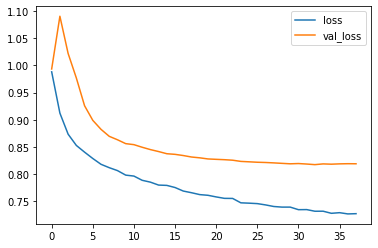

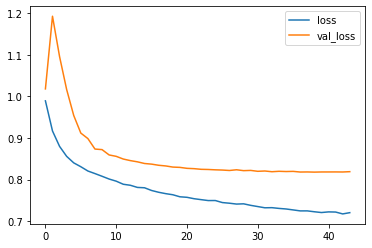

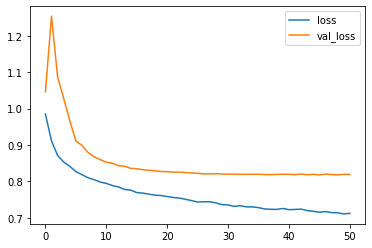

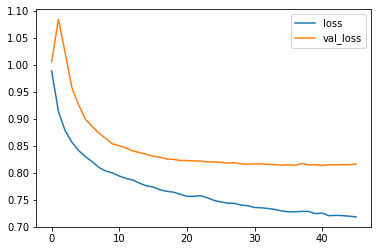

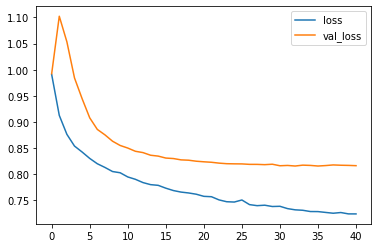

In [20]:
# Fit and evaluate 6 layer autoencoder for different sizes of bottleneck

autoenc_6layer_loss = list()

latent_space_size_list = list( np.arange(1, 20, 1) )
print( latent_space_size_list )

for latent_space_size in latent_space_size_list:
    
    print("Latent space size", latent_space_size)
    
    loss, fig = get_loss_autoencoder(x_val, get_6layer_autoencoder, latent_space_size, 100, verbose = '0',
                                    rescale = True, mean = data_dict["parameters"]["mean"], std = data_dict["parameters"]["std"],
                                    flux = data_dict["x_pooled"]["val_df_pooled_total_flux"])
    fig
    
    autoenc_6layer_loss.append( loss )

In [21]:
# Pickle the results for 6 layer autoencoder

# put results into a dictionary
autoenc_6layer_loss_dict = dict()
autoenc_6layer_loss_dict["loss"] = autoenc_6layer_loss
autoenc_6layer_loss_dict["dim"] = latent_space_size_list


In [22]:

# pickle
dump_object("6layer_autoencoder_loss_finegrid_wflux", autoenc_6layer_loss_dict)

()

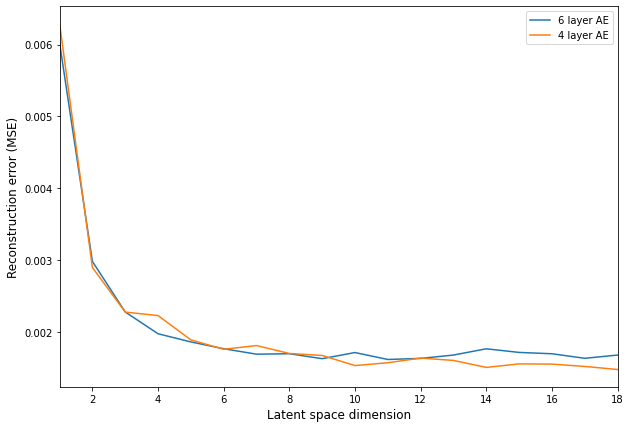

In [23]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(autoenc_6layer_loss_dict["dim"], autoenc_6layer_loss_dict["loss"], label = "6 layer AE")
ax.plot(autoenc_simple_loss_dict["dim"], autoenc_simple_loss_dict["loss"], label = "4 layer AE" )
ax.set_xlabel("Latent space dimension", fontsize = 12)
ax.set_ylabel("Reconstruction error (MSE)", fontsize = 12)
ax.set(xlim = (1,18) )
ax.legend();

# Final autoencoder

In [9]:
# def rescale_back(observation, mean, std):
#     return( observation*std + mean ) 

In [10]:
encoded_dim = 5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 264)            1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 5)              1325      
Total params: 2,906,909
Trainable params: 2,906,381
Non-trainable params: 528
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 264)            1584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 264)            1056      
_________________

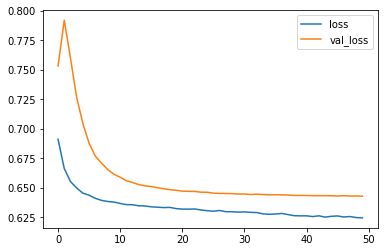

In [11]:
# Pick one model to train:

# autoencoder = get_simple_autoencoder(encoded_dim) 

encoder = Sequential([
    Dense(264, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l1(0)),
    BatchNormalization(),
    Dense(encoded_dim, activity_regularizer=regularizers.l1(0) ),
])
print(encoder.summary())

decoder = Sequential([
    Dense(264, input_shape = (1, encoded_dim), activation = 'relu', activity_regularizer=regularizers.l1(0)),
    BatchNormalization(),
    Dense(11001, activity_regularizer=regularizers.l1(0)),
])

print(decoder.summary())

autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
autoencoder.reset_states()

epochs = 50
verbose = 'auto'

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15)

autoencoder.compile(loss = 'mean_absolute_error', optimizer="Adam") # since output is zero or 1 use binary loss
# default optimiser: RMS propr
autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
                                verbose = verbose, callbacks = earlystopping)

fig, ax = plt.subplots()
ax.plot(autoenc_history.history["loss"], label = "loss")
ax.plot(autoenc_history.history["val_loss"], label = "val_loss")
ax.legend()

print(fig)

x_predicted_val = autoencoder.predict(test_dataset)

# def rescale_back(observation, mean, std):
#     '''
#     Reverse standardisation using the given parameters
#     '''
#     return( observation*std + mean ) 


mean = data_dict["parameters"]["mean"]
std =  data_dict["parameters"]["std"]
# x_val_rescaled = rescale_back(x_val, mean, std)
# x_predicted_val_rescaled = rescale_back( x_predicted_val, mean, std )

print("Prediction shape", x_predicted_val.shape)

# autoenc_loss = ((x_predicted_val_rescaled.ravel() - x_val_rescaled.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)
# print("Loss:", autoenc_loss)

In [12]:
x_projected_autoenc_tensor = encoder(x_val)
x_projected_autoenc = x_projected_autoenc_tensor.numpy()[:, 0, :]

In [13]:
data_dict["parameters"]["mean"]

array([0.00314746, 0.01770987, 0.03955527, ..., 0.01982372, 0.00398031,
       0.00090837])

In [14]:
x_predicted_val = autoencoder.predict(test_dataset)[:, 0, :]
# x_predicted_val_rescaled = rescale_back( x_predicted_val, mean, std )

# x_reconstructed_autoenc = x_predicted_val.numpy()[:, 0, :]

In [15]:
x_val_rescaled = rescale_back( x_val[:, 0,:].numpy(), mean, std ) 
x_val_rescaled_flux = x_val_rescaled[:, 0, :] * data_dict["x_pooled"]["val_df_pooled_total_flux"]
x_predicted_val_rescaled_flux = x_predicted_val_rescaled[:, 0, :] * data_dict["x_pooled"]["val_df_pooled_total_flux"]

TypeError: rescale_back() missing 1 required positional argument: 'flux'

In [42]:
data_dict["x_pooled"]["val_df_pooled_total_flux"] - data_dict["x_pooled"]["val_df_pooled_total_flux"]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [38]:
x_val_rescaled_flux = x_val[:, 0,:].numpy() * data_dict["x_pooled"]["val_df_pooled_total_flux"]
x_predicted_val_rescaled_flux = x_predicted_val * data_dict["x_pooled"]["val_df_pooled_total_flux"]

In [36]:
data_dict["x_pooled"]["val_df_pooled_total_flux"].shape

(1, 11001)

In [12]:
x_val_rescaled_flux = x_val_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"]
x_predicted_val_rescaled_flux = x_predicted_val_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"]

In [39]:
((x_val_rescaled_flux - x_predicted_val_rescaled_flux)**2).mean()

1580803.629519128

In [38]:
x_val_rescaled = rescale_back( x_val.numpy()[:, 0,:], mean, std ) 
x_val_rescaled

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [39]:
mean

nan

In [30]:
x_val_rescaled_flux.shape

TensorShape([430, 11001])

In [15]:
autoenc_4layer = dict()
autoenc_4layer["x_original_val"] = x_val
autoenc_4layer["x_projected_val"] = x_projected_autoenc
autoenc_4layer["x_reconstructed_val"] = x_predicted_val
autoenc_4layer["autoenc_history"] = autoenc_history.history # dictionary with all useful info 
# autoenc_history.save('outputs/simple_autoenc_history')

In [ ]:
# import os
# import pickle

# dump_object("simple_autoenc_object", autoenc_4layer)

## Signal recovery

In [14]:

random.seed(44223)
random_number_list = random.sample(range(x_val.shape[0]), 40, )

random_number_list = [194]

(1, 1, 11001)


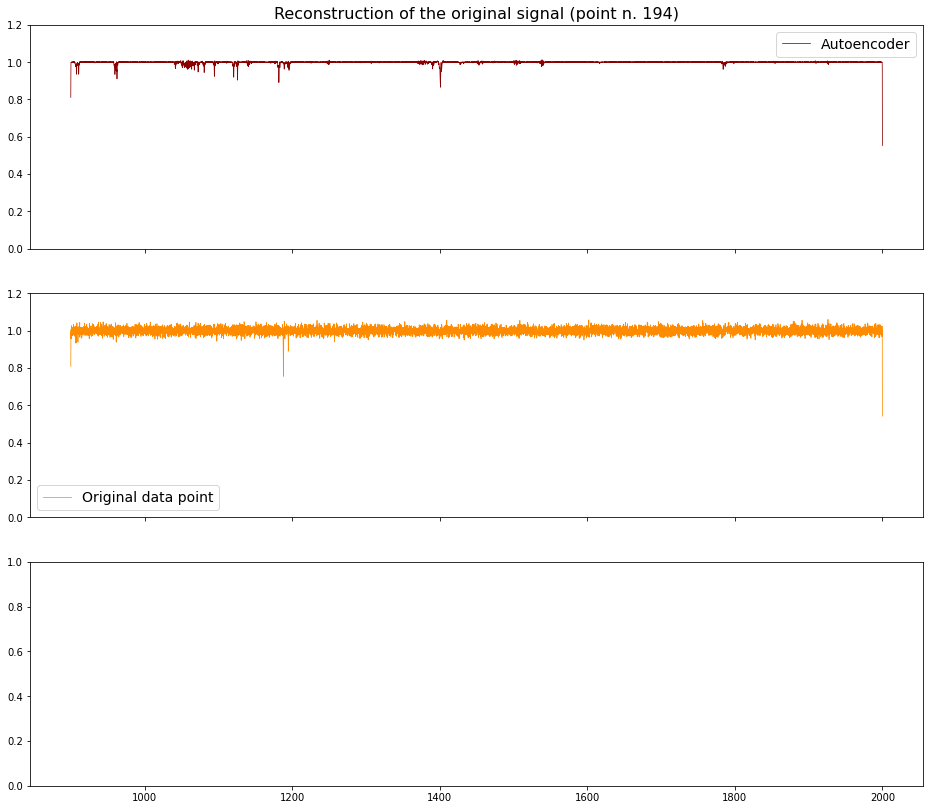

In [16]:
for random_number in random_number_list:
    x = tf.expand_dims(x_val[random_number, :], 1)
    x_projected = autoencoder.predict(x)
    x_projected_rescaled = rescale_back(x_projected, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 
    x_projected_rescaled = x_projected_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"] # [random_number, :]
    
    x_true_rescaled = rescale_back(x, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 
    x_true_rescaled = x_true_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"] # [random_number, :]
    print(x_true_rescaled.shape)
    fig, ax = plt.subplots(3, 1, sharex = True, figsize = (16, 14))
    ax[0].plot(data_dict["wavelengths"], x_projected_rescaled[0][0], label = "Autoencoder", linewidth = 0.75, color = "darkred")
    ax[0].legend(fontsize = 14)
    ax[0].set_ylim([0,1.2])
    
    ax[1].plot(data_dict["wavelengths"], x_true_rescaled[0][0], label = "Original data point", linewidth = 0.75, color = "darkorange")
    ax[1].legend(fontsize = 14)
    ax[1].set_ylim([0,1.2])
    
    ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number) + ")",
                   fontsize = (16));

In [42]:
x_projected_rescaled.shape

(1, 430, 11001)

In [40]:
data_dict["parameters"]["mean"]

array([7.47804775e-05, 8.87174306e-05, 9.10432213e-05, ...,
       8.91010594e-05, 7.78923726e-05, 5.08477837e-05])

In [39]:
x_projected.shape

(1, 1, 11001)

In [33]:
x_val[random_number, :]

<tf.Tensor: shape=(1, 11001), dtype=float64, numpy=
array([[-0.50839934, -0.69649217, -1.03619004, ..., -0.53390871,
        -1.21633376, -0.33535953]])>

In [30]:
x_true_rescaled[0]

<tf.Tensor: shape=(430, 11001), dtype=float64, numpy=
array([[0.80930916, 0.95703901, 0.97591533, ..., 0.96789868, 0.83232506,
        0.54188631],
       [0.80822546, 0.9557575 , 0.97460854, ..., 0.96660262, 0.83121055,
        0.54116071],
       [0.80846652, 0.95604255, 0.97489922, ..., 0.96689092, 0.83145846,
        0.54132211],
       ...,
       [0.80174384, 0.94809273, 0.96679259, ..., 0.95885088, 0.82454459,
        0.53682083],
       [0.79345323, 0.93828877, 0.95679526, ..., 0.94893568, 0.81601821,
        0.53126972],
       [0.80914256, 0.95684199, 0.97571443, ..., 0.96769943, 0.83215372,
        0.54177476]])>

In [31]:
x_true_rescaled[0][0]

<tf.Tensor: shape=(11001,), dtype=float64, numpy=
array([0.80930916, 0.95703901, 0.97591533, ..., 0.96789868, 0.83232506,
       0.54188631])>

In [46]:
x_true_rescaled[0][0]

<tf.Tensor: shape=(11001,), dtype=float64, numpy=
array([0.80976002, 0.95757217, 0.97645901, ..., 0.96843789, 0.83278875,
       0.5421882 ])>

In [54]:
mean = data_dict["parameters"]["mean"]
std =  data_dict["parameters"]["std"]
x_val_rescaled = rescale_back(x_val.numpy()[:,0,:], mean, std)
x_val_rescaled_flux = x_val_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"]

In [59]:
x_val_rescaled_flux

array([[0.80113647, 0.95586027, 0.97438402, ..., 0.99469935, 0.83811596,
        0.58066109],
       [0.79262418, 0.94985584, 1.00928017, ..., 0.94714131, 0.84335409,
        0.59968139],
       [0.81750669, 0.96579348, 0.98094038, ..., 0.96590885, 0.86320455,
        0.59877166],
       ...,
       [0.79855481, 0.92693663, 0.9840565 , ..., 0.96724595, 0.83844514,
        0.56546584],
       [0.80103545, 0.97278253, 0.99427281, ..., 0.95928068, 0.85912315,
        0.48934618],
       [0.83913666, 0.9643553 , 0.97546815, ..., 0.95498882, 0.82907042,
        0.49245257]])

In [58]:
data_dict["x_pooled"]['val']

,0,1,2,3,4,5,6,7,8,9,...,10991,10992,10993,10994,10995,10996,10997,10998,10999,11000
0,-0.839939,-0.742177,-1.100548,-1.666110,-0.200312,-1.702430,-1.282263,-0.595221,-0.483897,-0.027847,...,-1.039196,0.771327,0.192711,-0.636678,-1.439313,-0.205930,-0.385036,0.729383,-0.919338,0.432550
1,-1.142143,-0.925534,0.422949,-0.530772,-1.275997,-1.103106,-0.191830,-1.186078,-0.597019,-0.014111,...,-1.165823,-1.154442,0.223307,-1.421875,0.709919,-1.316766,-0.639970,-1.452479,-0.592697,0.825160
2,-0.141286,-0.318175,-0.782027,-0.790220,-0.388997,-0.970461,-0.322534,0.223397,-0.167552,-1.447966,...,-1.754763,-2.235737,-1.324259,-1.313493,-0.497929,-1.591131,-0.082456,-0.580248,0.413514,0.803578
3,0.331743,0.236598,0.364454,0.998440,0.322728,0.542714,0.016981,1.309046,0.514389,0.156410,...,1.196476,0.024161,0.733919,-0.440399,-1.704212,-0.580387,0.399553,0.840782,-0.171107,0.316734
4,-0.242389,-1.383048,0.164155,-0.817858,-1.535097,1.312224,-0.217351,0.038473,0.240787,-0.565100,...,-0.552908,0.368396,0.223186,-1.616415,-0.312260,-0.736637,-0.158833,-1.490030,-0.313452,-0.226275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,1.208790,-0.814134,-0.871812,-0.979517,-1.549504,-1.173828,0.266282,-0.747018,-0.226341,-0.781036,...,-0.807191,0.884090,-1.116409,-0.954695,-0.481752,0.286662,-0.318903,-0.536329,0.026434,-1.093501
426,-0.182433,-0.679827,-0.345697,-0.026202,-1.563586,-0.689373,-0.039257,-1.190997,-0.934217,-0.719256,...,0.175036,-0.415901,-1.492979,-0.170424,0.046732,-0.822976,-1.258934,-1.217066,1.797462,-0.380288
427,-0.638989,-1.524191,-0.303773,0.461496,-0.121192,-0.217637,-0.273865,-0.376454,0.149697,-0.005685,...,-1.375227,-0.679333,0.075697,-0.110406,-0.973209,1.874033,0.406269,-0.134460,-0.496694,0.237290
428,-0.194666,0.667123,0.570398,0.105297,0.968624,0.579884,-0.123685,1.364224,0.291685,-0.253771,...,2.413124,-0.362340,0.964682,-1.068894,0.573936,1.687617,-0.751514,-0.036536,1.038552,-1.182220
